# <center>Predicting the potentially gold customers</center>
## <center>Provided by: Mansour Movahhedinia</center>
### <center><font color=red>!!!Since the dataset used in this project is private, the data is not shown whenever necessary!!!</font></center>
#### <center>The goal of the project is to find the features on the occurrence of which a customer is most probable to become a gold customer and develop a model to predict which customers are most likely to become gold customers.</center>

--------------------------------

#### 1. Importing the libraries used in the project and setting up the environment.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import sys
import matplotlib
import matplotlib.pyplot as plt
import os
import glob
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
tqdm.pandas(desc="Progress: ")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
get_ipython().magic('matplotlib inline')
matplotlib.style.use('ggplot')

#### 2. Creating the functions used in the project.

In [2]:
def reader(inform, suffix):
    '''
        This function reads the given files into dataframes. Creates the variables globally. Adds the name of the dataframe to itself
        as an attribute called name.
        Arguments:
        inform: A dictionary containing the name of the dataframe as key and location of the file for that dataframe as value.
        suffix: The suffix which is placed after the name of the dataframes.
        Since the variables are defined globally it returns nothing.
    '''
    for key, value in tqdm(inform.items(), desc='Progress: '):
        var = key + suffix
        globals()[var] = pd.read_csv(value, na_values=".")
        exec(var + '.name = "' + key + suffix + '"')


def subsetter(*data, criterion, col):
    '''
        This function subsets all the given dataframes based on a single criterion.
        Arguments:
        Data: The datraframes.
        criterion: A series based on which subsetting has to be done.
        col: The name of the column to be compared to the criterion.
        Returns the dataframes passed to it but what is left of them after subsetting.
    '''
    source = list(data)
    for i in tqdm(range(len(source)), desc='Progress: '):
        source[i] = source[i][source[i][col].isin(criterion)]
    return source


def dummy(data):
    '''
    This function creates dummy variables for any column in a dataframe has missing values. It takes the dataframe
    as its argument.
    Returns the new dataframe but solely for the purpose of printing the data.
    '''
    for i in tqdm(data.columns, desc='Progress: '):
        if data[i].isnull().any():
            data['dummy_'+i] = data[i].map(lambda x: int(pd.isnull(x)))
        else:
            pass
    return data


def numer(data):
    '''
    Converts all non-numeric columns of a dataframe to numeric.
    Arguments:
    Just the dataframe itself.
    Returns the new dataframe but solely for the purpose of printing the data.
    '''

    for i in tqdm(data.columns, desc='Progress: '):
        if data[i].dtype == 'object':
            uniques = data[i].unique()
            for j in range(len(uniques)):
                data[i].replace(uniques[j], j+1, inplace=True)
    return data


def no_na(data):
    '''
    A simplified way to replace missing values with 0. Gets the name of a dataframe as argument.
    Takes a dataframe as argument.
    Returns the new dataframe but solely for the purpose of printing the data.
    '''
    data.fillna(0, inplace=True)
    return data


def merger(*sources, col, type_):
    '''
    Merges the given dataframes based on a single given column and merge type. Prints the number of the dataframe it
    is working on unless it is the last dataframe for which the operation finishes instead.
    Arguments:
    sources: The dataframes.
    col: Name of the column which the merging should be based on. This name has to be the same across all dataframes.
    type_: Type of the merge.
    Returns the resulting dataframe after the final merge.
    '''
    temp = sources[0].copy()
    i = 1
    while i < len(sources):
        sys.stdout.write("\r" + str(i))
        sys.stdout.flush()
        temp = temp.merge(sources[i], on=col, how=type_)
        i += 1
    return temp


def ploter(data, labels, dotspi=None, size=None, y_label=None, x_label=None, t_title=None):
    '''
    Plots a bar chart from the data passed to it.
    Arguments:
    data: The data to be plotted.
    labels: Labels of each bar on the x axis.
    size: Size of the figure. Optional.
    dotspi: Quality of the image created. Optional.
    y_label: Label of the y axis.
    x_label: label of the x axis.
    t_title: Title of the plot.
    Returns the chart object which can be plotted.
    '''
    N = len(data)
    ind = np.arange(N)
    width = 0.3

    fig, ax = plt.subplots(dpi=dotspi, figsize=size)
    ewcts = ax.bar(ind, data, width, color='b', alpha=0.5)

    ax.set_ylabel(y_label)
    ax.set_title(t_title)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    ax.set_xlabel(x_label)
    plt.tight_layout()
    return plt


def missing_cal(*operations, source):
    '''
    Calculates the percent of the missing or none-missing values in a dataframe. It can calculate for the whole dataframe or each column.
    Arguments:
    operations: Operations to be performed.
    source: The dataframe.
    Returns a dictionary containing the result of the calculation(s).
    '''
    message = {}
    for i in tqdm(operations, desc='Progress: '):
        if i == 'percent_total':
            message['Percentage of total missing values: '] = ((source.isnull().sum().sum())/(source.shape[0]*source.shape[1]))*100
        elif i == 'percent':
            message["Percentage of each column's missing values: "] = pd.DataFrame(source.isnull().sum()/len(source)*100, columns=['Percent'])
        elif i == 'non_percent_total':
            message['Percentage of total none-missing values: '] = ((source.notnull().sum().sum())/(source.shape[0]*source.shape[1]))*100
        elif i == 'non_percent':
            message["Percentage of each column's non-missing values: "] = pd.DataFrame(source.notnull().sum()/len(source)*100, columns=['Percent'])
    return message

# def FeatureMaker(source, criteria_col, f_data):
#     for key, value in f_data.items():
#         for i in source[criteria_col].unique():
#             source.set_value(source[source[criteria_col] == i].index.tolist(), key, exec('source[source[criteria_col] == i]["' + value[0] + '"].' + value[1] + '()'))
# #             source.set_value(exec(value[0]), key, exec(value[1]))
#     return source


def FeatureMaker(source, criteria_col, f_data):
    '''
    This function creates new features for the given columns by calculating and storing their sum, mean, and standard deviation based on either
    one or two criteria which in turn is from the unique values of the source dataframe's column(s). An attempt was made to make this more
    dynamic but it was not necessary for the project and a problem was found in python's source which made a more dynamic approach problematic
    when used in pandas.
    Arguments:
    source: The dataframe which the features are supposed to be added to.
    criteria_col: The column(s) which hold the criterion or criteria.
    f_data: A dictionary. The keys of this dictionary are the name of the new features and the values are lists containing the source columns
    and the calculation which has to be made.
    Returns the new dataframe but solely for the purpose of printing the data.
    '''
    if len(criteria_col) == 1:
        for key, value in f_data.items():
            for i in source[criteria_col[0]].unique():
                if value[1] == 'sum':
                    source.set_value(source[source[criteria_col[0]] == i].index.tolist(), key, source[source[criteria_col[0]] == i][value[0]].sum())
                elif value[1] == 'mean':
                    source.set_value(source[source[criteria_col[0]] == i].index.tolist(), key, source[source[criteria_col[0]] == i][value[0]].mean())
                elif value[1] == 'std':
                    source.set_value(source[source[criteria_col[0]] == i].index.tolist(), key, source[source[criteria_col[0]] == i][value[0]].std())
    elif len(criteria_col) == 2:
        for key, value in f_data.items():
            for i in source[criteria_col[0]].unique():
                for j in source[criteria_col[1]].unique():
                    if value[1] == 'sum':
                        source.set_value(source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)].index.tolist(), key + '_' + j, source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)][value[0]].sum())
                    elif value[1] == 'mean':
                        source.set_value(source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)].index.tolist(), key + '_' + j, source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)][value[0]].mean())
                    elif value[1] == 'std':
                        source.set_value(source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)].index.tolist(), key + '_' + j, source[(source[criteria_col[0]] == i) & (source[criteria_col[1]] == j)][value[0]].std())

    return source


def FeatureMaker_spend(source):
    '''
    Same as the featuremaker function but only for the spend dataframe of this project. The needs of the spend dataframe are more than
    the rest of the dataframes and the featuremaker function cannot cover them all. Since making the featuremaker function more dynamic
    ran into a problem with python's source code, this function was created to cover what the previous couldn’t.
    Arguments:
    source: The dataframe.
    Returns the new dataframe but solely for the purpose of printing the data.
    '''
    source['total_spend_sum'] = source['spend'].sum()
    source['total_spend_mean'] = source['spend'].mean()
    source['total_spend_std'] = source['spend'].std()
    for j in source['spend_type'].unique():
        criteria = spend['Month_ID'].unique()[-3:]
        source['3_months_spend_mean'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].mean()
        source['3_months_spend_sum'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].sum()
        source['3_months_spend_std'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].std()
        criteria = spend['Month_ID'].unique()[-6:]
        source['6_months_spend_mean'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].mean()
        source['6_months_spend_sum'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].sum()
        source['6_months_spend_std'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].std()
        criteria = spend['Month_ID'].unique()[-4:]
        source['4_months_spend_mean'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].mean()
        source['4_months_spend_sum'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].sum()
        source['4_months_spend_std'] = source[(source['Month_ID'].isin(criteria)) & (source['spend_type'] == j)]['spend'].std()
    return source


#### 3. Reading the files into dataframes.

In [3]:
reader({'target': 'E:/prj_gold/target.csv',
        'service': 'E:/prj_gold/service.csv',
        'spend': 'E:/prj_gold/spend.csv',
        'coupon': 'E:/prj_gold/coupon.csv',
        'customers': 'E:/prj_gold/customers.csv',
        'demo_real': 'E:/prj_gold/demo_real.csv'}, '_source')

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  3.49s/it]


#### 4. Creating a sample data.

At first the sample was selected from the target_source dataframe. But later on, since spend_source was a better representative of the population the sample was created from spend_source.

In [4]:
ids = np.random.choice(spend_source['id'].unique(), size=300000)

The <i>ids</i> variable holds of 300000 id numbers selected randomly from the unique values of the id column in spend_source. The next step is to remove any observation whose id value is not in <i>ids</i> from all of the dataframes.

In [5]:
target_source, spend_source, service_source, coupon_source, customers_source = subsetter(target_source, spend_source, service_source, coupon_source,
                                                                                         customers_source, col='id', criterion=ids)

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.08it/s]


Since the <i>demo_real_source</i> dataframe does not have an id column, the subsetting was done based on the postcode. Furthermore, the name of this column is changed to the name of the column holding the postal codes in the <i>customers_source</i> dataframe to make things easier later on.

In [6]:
demo_real_source.rename(columns={'POSTCODE': 'postcode'}, inplace=True)
demo_real_source = demo_real_source[demo_real_source['postcode'].isin(customers_source['postcode'])]

#### 5. Having a look at each dataframe.

###### 1. target_source

In [7]:
target_source.head()

,id,gold
187,3.0,0
188,8.0,1
189,9.0,0
194,43.0,1
196,54.0,0


No duplications in the target_source. That's nice!

In [8]:
target_source.duplicated('id').any()

False

The target_source dataframe actually does have missing values but their number is so few that none were selected in our sample. So... no need to fix anything.

In [9]:
missing = missing_cal('percent_total', 'percent', source=target_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 153.45it/s]


Percentage of total missing values: 
0.0


Percentage of each column's missing values: 
      Percent
id        0.0
gold      0.0




The portion of the zeros is way more than the ones. That means the number of non-gold customers in the sample is much less than the other group. Although the actual data was about 60000 rows more than the sample, it is safe to assume such a difference in numbers exist even in the source data.

<function matplotlib.pyplot.show>

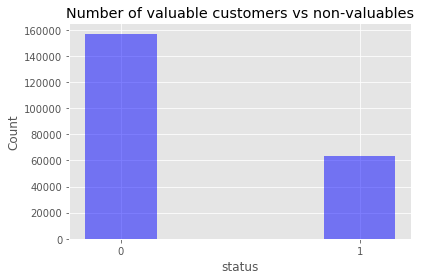

In [10]:
ploter(target_source.groupby('gold')['id'].count(), target_source['gold'].unique(), y_label='Count', x_label='status',
       t_title='Number of valuable customers vs non-valuables').show

The target_source dataframe is in good shape. No need to change anything.

##### 2. spend_source

In [11]:
spend_source.head()

,id,spend_day,spend_type,spend
0,3,29AUG2005,g,1.3
1,3,19SEP2005,g,1.3
2,8,07MAY2005,s,10.8
3,8,12MAY2005,g,1.5
4,8,14MAY2005,s,16.1


There are duplications in spend_source. That means there are ids which have more than one spend record.

In [12]:
spend_source.duplicated('id').any()

True

Good! No missing values in spend_source!

In [13]:
missing = missing_cal('percent_total', 'percent', source=spend_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.85it/s]


Percentage of total missing values: 
0.0


Percentage of each column's missing values: 
            Percent
id              0.0
spend_day       0.0
spend_type      0.0
spend           0.0




Given that the mean of the spend column of the spend_source dataframe is in the upper quantile, there may be outliers in the data. Furthermore, the fact that the minimum spend is negative seems strange. No data has been provided to weather this is wrong or not so it will be ignored for now.

In [14]:
spend_source['spend'].describe()

count    6.443092e+06
mean     1.266429e+01
std      7.263813e+01
min     -9.976200e+03
25%      1.600000e+00
50%      3.400000e+00
75%      7.200000e+00
max      3.494750e+04
Name: spend, dtype: float64

There is a huge difference in the portion of spend type g to the other two. I wonder what g means? Unfortunately, no data is provided.

<function matplotlib.pyplot.show>

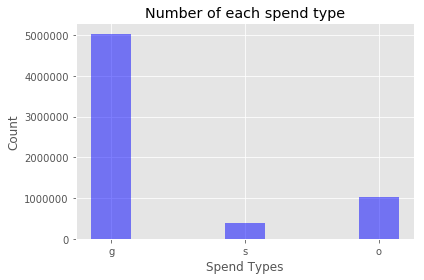

In [15]:
ploter(spend_source.groupby(['spend_type'])['spend'].count(), spend_source['spend_type'].unique(), y_label='Count', x_label='Spend Types',
       t_title='Number of each spend type').show

It is interesting that the people who have used spend_type o have spent more. Although their number is much less than type g, they have more aptitude to spend more. The o type seems to be a payment method which allows people to make large payments. But that is a wild guess. The two plots are too far away at this stage for any conclusion.

<function matplotlib.pyplot.show>

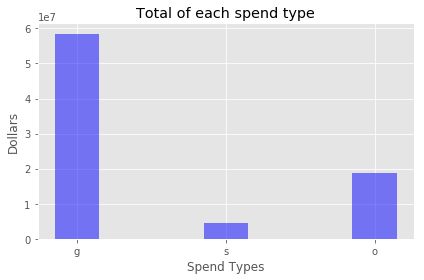

In [16]:
ploter(spend_source.groupby(['spend_type'])['spend'].sum(), spend_source['spend_type'].unique(), y_label='Dollars', x_label='Spend Types',
       t_title='Total of each spend type').show

Extracting the months of the payments. The data starts from January 2005 and goes until February 2006. So, it is easier to directly extract the month with a simple replacement rather than a conversion to date format, although a date format may be required further on. Since it is not really important in which month the payments have been made but rather when, a simple numbering would do the trick. This will create a positional index which will tell us which payment was made in the last month, which in the last two months, and such. That is the data I am looking for.

In [17]:
spend_source['Month_ID'] = spend_source['spend_day'].progress_map(lambda x: x[2:]).replace({'JAN2005': 1, 'FEB2005': 2, 'MAR2005': 3, 'APR2005': 4, 'MAY2005': 5,
                                                                                            'JUN2005': 6, 'JUL2005': 7, 'AUG2005': 8, 'SEP2005': 9, 'OCT2005': 10,
                                                                                            'NOV2005': 11, 'DEC2005': 12, 'JAN2006': 13, 'FEB2006': 14})

Progress: : 100%|███████████████████████████████████████████████████████| 6435136/6435136 [00:04<00:00, 1461813.00it/s]


Since the spend_source dataframe is huge, it is too demanding to make detailed features. That means, the system this project was created on could not handle it. Therefore, the dataframe was broken into chunks based on the ids. Meaning, each id's transactions were saved in a separate file to be read and processed individually later on.

In [18]:
ids = spend_source['id'].unique()
for i in tqdm(ids, desc='Progress: '):
    spend_source[spend_source['id'] == i].to_csv('E:/prj_gold/temps/spend_' + str(i) + '.csv', index=False)

Progress: : 100%|███████████████████████████████████████████████████████████████████| 300000/300000 [01:27<00:00, 966.91it/s]


Afterwards, each file is read and new features were created for it. Furthermore, after reading each file it was either written to a new file called final_sum.csv if it was the first file, or appended to final_sum.csv if it wasn't the first file. Being the first file also means final_sum.csv has not been created yet. Consequently, the spend_source dataframe was recreated again with some new features. These new features were: sum, mean, and std of total spend of each id and their spend for each spend type in the last 3, 4, and 6 months.

In [19]:
path = r'E:/prj_gold/temps/'
targetfile = 'E:/prj_gold/temps/final_sum.csv'
all_files = glob.glob(os.path.join(path, "*.csv"))
for file in tqdm(all_files, desc='Progress: '):
    spend = pd.read_csv(file)
    if not os.path.isfile(targetfile):
        FeatureMaker_spend(spend).to_csv(targetfile, index=False)
    else:
        FeatureMaker_spend(spend).to_csv(targetfile, mode='a', index=False, header=False)
spend_source = pd.read_csv(targetfile)
spend = None  # Sometimes just deleting a variable doesn't free the memory.
del spend

Progress: : 100%|██████████████████████████████████████████████████████████████████| 300000/300000 [12:48<00:00, 44.60it/s]


Now we have a fine spend_source dataframe. Great!

##### 3. service_source

Same procedure.

In [20]:
missing = missing_cal('percent_total', 'percent', source=service_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 79.79it/s]


Percentage of total missing values: 
0.0


Percentage of each column's missing values: 
               Percent
id                 0.0
service_day        0.0
service_count      0.0




Some ids have contacted customer service more than once.

In [21]:
service_source.duplicated('id').any()

True

In [22]:
service_source.head()

,id,service_day,service_count
7,43,13FEB2005,1
8,43,14FEB2005,1
9,43,23MAR2005,1
10,138,24FEB2005,1
12,196,03OCT2005,1


In [23]:
service_source['service_count'].describe()

count    222720.000000
mean          1.015432
std           0.160089
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: service_count, dtype: float64

The results below are more information rich than the ones above since the ones below are grouped by id. As it turns out, some guy has called customer service 394 times!!! I think we have an outl... a record!

In [24]:
service_source.groupby('id').sum().describe()

,service_count
count,57836.000000
mean,3.910315
std,9.318748
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,394.000000


Finding the year in which the service was provided. Again, doing it directly without converting to date format because it is faster.

In [25]:
service_source['service_year'] = service_source['service_day'].progress_map(lambda x: x[-4:])

Progress: : 100%|█████████████████████████████████████████████████████████| 224397/224397 [00:00<00:00, 1345090.24it/s]


And then, checking to see how many years we have. Only 2005!

In [26]:
service_source['service_year'].unique()

array(['2005'], dtype=object)

I was going to calculate total service of each person in each year but since we have one year I'll just go with the total service.

In [27]:
for i in tqdm(service_source['id'].unique()):
    service_source.set_value(service_source[(service_source['id'] == i)].index.tolist(), 'total_service', service_source[(service_source['id'] == i)]['service_count'].sum())

100%|███████████████████████████████████████████████████████████████████████████| 57723/57723 [02:23<00:00, 401.41it/s]


In [28]:
service_source.head()

,id,service_day,service_count,service_year,total_service
11,141,02MAR2005,1,2005,1.0
20,347,24JAN2005,1,2005,1.0
21,364,23FEB2005,1,2005,1.0
22,379,02JUN2005,1,2005,2.0
23,379,02JUN2005,1,2005,2.0


That is it for this dataframe for now.

##### 4. coupon_source

In [29]:
missing = missing_cal('percent_total', 'percent', source=coupon_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 166.23it/s]


Percentage of total missing values: 
0.0


Percentage of each column's missing values: 
            Percent
id              0.0
coupon_day      0.0
amount          0.0




In [30]:
coupon_source.duplicated('id').any()

True

In [31]:
coupon_source.head()

,id,coupon_day,amount
10,347,03/29/2005,35.0
11,347,05/06/2005,32.1
12,424,08/12/2004,19.8
13,424,06/28/2005,24.3
32,505,01/18/2005,9.3


We have a coupon champ!

In [32]:
coupon_source.groupby('id').sum().describe()

,amount
count,38168.000000
mean,38.572744
std,39.171480
min,3.300000
25%,17.500000
50%,27.600000
75%,45.800000
max,952.500000


The champ had 63 coupons! An insider?

In [33]:
coupon_source.groupby('id')['amount'].count().describe()

count    38168.000000
mean         2.035187
std          2.037082
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         63.000000
Name: amount, dtype: float64

Same as before, extracting the year of each coupon.

In [34]:
coupon_source['coupon_year'] = coupon_source['coupon_day'].progress_map(lambda x: x[-4:])

Progress: : 100%|███████████████████████████████████████████████████████████| 78394/78394 [00:00<00:00, 1013870.27it/s]


2005 and... 2004?! Ahmmm... ok...

In [35]:
coupon_source['coupon_year'].unique()

array(['2005', '2004'], dtype=object)

New features for total coupon per id and total coupon per id in each year. I know I can do it by groupby and converting it to a dataframe and all. But this was simpler for me. Less coding!

In [36]:
for i in tqdm(coupon_source['id'].unique()):
    coupon_source.set_value(coupon_source[(coupon_source['id'] == i)].index.tolist(), 'total_coupon', coupon_source[(coupon_source['id'] == i)]['amount'].sum())
    for j in coupon_source['coupon_year'].unique():
        coupon_source.set_value(coupon_source[(coupon_source['id'] == i)].index.tolist(), 'total_coupon_' + j, coupon_source[(coupon_source['id'] == i) & (coupon_source['coupon_year'] == j)]['amount'].sum())

100%|███████████████████████████████████████████████████████████████████████████████| 164/164 [00:00<00:00, 253.36it/s]


In [37]:
coupon_source.head()

,id,coupon_day,amount,coupon_year,total_coupon,total_coupon_2005,total_coupon_2004
1785,39076,03/14/2005,19.8,2005,19.8,19.8,0.0
6027,129130,07/19/2004,5.1,2004,5.1,0.0,5.1
7544,159983,06/28/2004,24.3,2004,24.3,0.0,24.3
14633,312073,12/02/2004,16.5,2004,36.9,0.0,36.9
14634,312073,12/13/2004,20.4,2004,36.9,0.0,36.9


End of coupon_source!!!

##### 5. customers_source

Column <i>Unnamed: 0</i> is actually the row indexes. Why do we have the row indexes as a column too?! Let's get rid of it!

In [38]:
customers_source.head(0)  # Sorry, can't show the data...

,Unnamed: 0,id,internet_day,postcode,Lan_spoken,birth,prin_payment,income,sex,credit_flag,email_home,email_office,mail_receive_tp,mail_flag,business_flag,reg_day


There, much better...

In [39]:
del customers_source['Unnamed: 0']

In [40]:
customers_source.duplicated('id').any()

False

In [41]:
customers_source[['prin_payment', 'income']].describe()

,prin_payment,income
count,159187.000000,21202.000000
mean,1740.233863,32789.570984
std,867.713675,10170.506991
min,400.000000,19005.000000
25%,1000.000000,22863.250000
50%,1520.000000,30971.000000
75%,2313.000000,41252.000000
max,4000.000000,66347.000000


Wow... missing values. Lots of missing values in income and sex columns. Specially income.

In [42]:
missing = missing_cal('percent_total', 'percent', source=customers_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.79it/s]


Percentage of total missing values: 
15.159490690380363


Percentage of each column's missing values: 
                   Percent
Unnamed: 0        0.000000
id                0.000000
internet_day      9.000508
postcode          0.133254
Lan_spoken       19.997099
birth             2.925686
prin_payment     27.991407
income           90.378096
sex              38.497589
credit_flag       8.626582
email_home        9.957758
email_office     15.065811
mail_receive_tp   3.005457
mail_flag         9.946427
business_flag     7.026179
reg_day           0.000000




Ok, since I want to calculate age and length of membership of each customer I have to convert birth and reg_day to datetime format.

In [43]:
today = pd.to_datetime('today')
customers_source['birth'] = pd.to_datetime(customers_source['birth'], format='%Y-%m-%d')
customers_source['age'] = (today - customers_source['birth']).astype('<m8[Y]').astype('int', errors='ignore')
customers_source['reg_day'] = pd.to_datetime(customers_source['reg_day'], format='%Y-%m-%d')
customers_source['member_hlong'] = (today - customers_source['reg_day']).astype('<m8[Y]').astype('int', errors='ignore')

In [44]:
customers_source.head(0)  # Sorry, can't show the data...

,id,internet_day,postcode,Lan_spoken,birth,prin_payment,income,sex,credit_flag,email_home,email_office,mail_receive_tp,mail_flag,business_flag,reg_day


That is it for customers_source for now...

#### 5. demo_real_source

In [45]:
demo_real_source.head(0)  # Sorry, can't show the data...

,postcode,num_family,num_dwell,num_rent,num_househd,emp_num,emp_num_child,TV_view_light,TV_view_medium,TV_view_heavy,paper_read_light,paper_read_medium,paper_read_heavy,internet_home,internet_work,internet_school,fin_saving,fin_checking,fin_draft,fin_banking,fin_morgage,fin_auto,fin_linecredit,fin_loan,fin_resp,fin_estate,credit_amex,credit_master,credit_visa,iga,loblaw,safeway,drugstore,online,Mac,london_drug,pharmaplus,shopdrug,bay,sears,walmart,zellers,chpater,ikea,leons,canadiantire,bestbuy,futureshop,redioshack,staple,off_depot,food_takeout,food_takeout_l1m,food_takeout_1m,resta_never,resta_never_l1m,resta_never_1m,drive_none,drive_p_1,drive_p_2,drive_p_3,drive_p_4,lottery,coupon_never,coupon_seldom,coupon_freq,males,females,single,married,separate,divorce,widow,child_1,child_2,num_non_fam,num_fam,fam_1_hd,fam_m_hd,non_fam_hd,dwelling_own,dwelling_rent,ever_school,edu_college,edu_university,num_inc_pop,income_none,income_with,avg_inc,inc_p_1,inc_p_2,inc_p_3,inc_p_4,inc_p_5,inc_p_6,inc_p_7,inc_p_8,inc_p_9,inc_p_10,employed,unemployed,tran_car,tran_pub,tran_walk,english_work,french_work,pop_native_lan,imm_1g,imm_2g,flow_money,rsp,avg_refri,avg_tel,food,Accomm,mortgage,maintenance,property_tax,water,tel,cellilar,internet,childcare,pet,garden,clothing,transportation,priv_trans,health,recreation,reading,personal_tax,personal_insur,life_insur,EI,pension,age_2130,age_3140,age_4150,age_5160,age_6170,age_7180,age_80_O,pop_num


Since postcode is acting as an id here...

In [46]:
demo_real_source['postcode'].duplicated().any()

False

A lot of stuff... most not useful... well filter them later on.

In [47]:
demo_real_source.describe()

,num_family,num_dwell,num_rent,num_househd,emp_num,emp_num_child,TV_view_light,TV_view_medium,TV_view_heavy,paper_read_light,paper_read_medium,paper_read_heavy,internet_home,internet_work,internet_school,fin_saving,fin_checking,fin_draft,fin_banking,fin_morgage,fin_auto,fin_linecredit,fin_loan,fin_resp,fin_estate,credit_amex,credit_master,credit_visa,iga,loblaw,safeway,drugstore,online,Mac,london_drug,pharmaplus,shopdrug,bay,sears,walmart,zellers,chpater,ikea,leons,canadiantire,bestbuy,futureshop,redioshack,staple,off_depot,food_takeout,food_takeout_l1m,food_takeout_1m,resta_never,resta_never_l1m,resta_never_1m,drive_none,drive_p_1,drive_p_2,drive_p_3,drive_p_4,lottery,coupon_never,coupon_seldom,coupon_freq,males,females,single,married,separate,divorce,widow,child_1,child_2,num_non_fam,num_fam,fam_1_hd,fam_m_hd,non_fam_hd,dwelling_own,dwelling_rent,ever_school,edu_college,edu_university,num_inc_pop,income_none,income_with,avg_inc,inc_p_1,inc_p_2,inc_p_3,inc_p_4,inc_p_5,inc_p_6,inc_p_7,inc_p_8,inc_p_9,inc_p_10,employed,unemployed,tran_car,tran_pub,tran_walk,english_work,french_work,pop_native_lan,imm_1g,imm_2g,flow_money,rsp,avg_refri,avg_tel,food,Accomm,mortgage,maintenance,property_tax,water,tel,cellilar,internet,childcare,pet,garden,clothing,transportation,priv_trans,health,recreation,reading,personal_tax,personal_insur,life_insur,EI,pension,age_2130,age_3140,age_4150,age_5160,age_6170,age_7180,age_80_O,pop_num
count,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,1.398990e+05,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.0,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.00000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000,139899.000000
mean,33.387515,46.094475,15.435907,46.094475,96.362533,36.817526,0.203954,0.320397,0.474201,0.197668,0.219445,0.266271,0.735596,0.561186,0.228188,0.826072,0.934307,0.487427,0.277795,0.451215,0.242817,0.498707,0.138562,0.169115,0.043416,0.134617,0.469895,0.661220,0.354390,0.260411,0.253808,0.714853,0.015769,0.180778,0.197965,0.139416,0.645204,0.622414,0.712502,0.859140,0.771104,0.532815,0.445122,0.136727,0.849454,0.230452,0.550592,0.423806,0.713655,0.193110,0.164475,0.357080,0.211984,0.065085,0.218266,0.231198,0.053612,0.224609,0.321716,0.244634,0.155429,0.

No missing values... niiiiice!!!

In [48]:
missing = missing_cal('percent_total', 'percent', source=demo_real_source)
for key, value in missing.items():
    print(key)
    print(value)
    print('\n')

Progress: : 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.54it/s]


Percentage of total missing values: 
0.0


Percentage of each column's missing values: 
                   Percent
postcode               0.0
num_family             0.0
num_dwell              0.0
num_rent               0.0
num_househd            0.0
emp_num                0.0
emp_num_child          0.0
TV_view_light          0.0
TV_view_medium         0.0
TV_view_heavy          0.0
paper_read_light       0.0
paper_read_medium      0.0
paper_read_heavy       0.0
internet_home          0.0
internet_work          0.0
internet_school        0.0
fin_saving             0.0
fin_checking           0.0
fin_draft              0.0
fin_banking            0.0
fin_morgage            0.0
fin_auto               0.0
fin_linecredit         0.0
fin_loan               0.0
fin_resp               0.0
fin_estate             0.0
credit_amex            0.0
credit_master          0.0
credit_visa            0.0
iga                    0.0
loblaw                 0.0
safeway                0.0
drugstore            

After double checking, I found out that the missing values are presented by <i>?</i>. A missing is a missing therfore, replacing.

In [49]:
demo_real_source.replace({'?': np.nan}, inplace=True)

End of demo_real!!!

#### 6. Now that we have created all the id specific features for the dataframes. Let's remove the duplicates and merge them into one big dataframe.

In [50]:
spend_source = spend_source.drop_duplicates(subset=['id'], keep='first')
coupon_source = coupon_source.drop_duplicates(subset=['id'], keep='first')
service_source = service_source.drop_duplicates(subset=['id'], keep='first')

Pay attention that the type of the merge is left and the dataframe I got the sample from is the left most one. This will insure all the 300000 records in the sample are included and if any of them is missing in the other dataframes it will create a missing value for them. That means even if a dataframe did not have any missing values up until now, it still may create missing values in the merged dataframe. The missing values are handled later on.

In [51]:
merged = merger(spend_source, target_source, service_source, coupon_source, customers_source, col='id', type_='left').merge(demo_real_source, on='postcode', how='left')

4

#### 7. And clear up the memory.

In [52]:
target_source = None  # As mentioned before, this line and the lines like this are placed in case of situations
                      # where deleting the variable would not free up the memory. I don't know why that happens
                      # but assigning None to the variables before deleting solves the problem to some extent.
del target_source
service_source = None
del service_source
spend_source = None
del spend_source
coupon_source = None
del coupon_source
customers_source = None
del customers_source
demo_real_source = None
del demo_real_source

#### 8. Fixing what we left behind and saveing the progress so far.

In [53]:
merged['service_day'] = pd.to_datetime(merged['service_day'], format='%d%b%Y')
merged['coupon_day'] = pd.to_datetime(merged['coupon_day'], format='%m/%d/%Y')
merged['spend_day'] = pd.to_datetime(merged['spend_day'], format='%d%b%Y')
merged.to_csv('E:/prj_gold/merged.csv', index=False)

#### 9. Now it is the time to work on the merged data.

First, lets create the dummy variables and remove the missing.

In [54]:
dummy(merged)
no_na(merged)
merged.head(0)

Progress: : 100%|█████████████████████████████████████████████████████████████████| 346/346 [00:21<00:00, 10178.93it/s]


,id,gold,service_day,service_count,spend_day,spend_type,spend,Month_ID,total_spend_sum,total_spend_mean,total_spend_std,3_months_spend_mean,3_months_spend_sum,3_months_spend_std,6_months_spend_mean,6_months_spend_sum,6_months_spend_std,4_months_spend_mean,4_months_spend_sum,4_months_spend_std,coupon_day,amount,internet_day,postcode,Lan_spoken,birth,prin_payment,income,sex,credit_flag,email_home,email_office,mail_receive_tp,mail_flag,business_flag,reg_day,num_family,num_dwell,num_rent,num_househd,emp_num,emp_num_child,TV_view_light,TV_view_medium,TV_view_heavy,paper_read_light,paper_read_medium,paper_read_heavy,internet_home,internet_work,internet_school,fin_saving,fin_checking,fin_draft,fin_banking,fin_morgage,fin_auto,fin_linecredit,fin_loan,fin_resp,fin_estate,credit_amex,credit_master,credit_visa,iga,loblaw,safeway,drugstore,online,Mac,london_drug,pharmaplus,shopdrug,bay,sears,walmart,zellers,chpater,ikea,leons,canadiantire,bestbuy,futureshop,redioshack,staple,off_depot,food_takeout,food_takeout_l1m,food_takeout_1m,resta_never,resta_never_l1m,resta_never_1m,drive_none,drive_p_1,drive_p_2,drive_p_3,drive_p_4,lottery,coupon_never,coupon_seldom,...,dummy_leons,dummy_canadiantire,dummy_bestbuy,dummy_futureshop,dummy_redioshack,dummy_staple,dummy_off_depot,dummy_food_takeout,dummy_food_takeout_l1m,dummy_food_takeout_1m,dummy_resta_never,dummy_resta_never_l1m,dummy_resta_never_1m,dummy_drive_none,dummy_drive_p_1,dummy_drive_p_2,dummy_drive_p_3,dummy_drive_p_4,dummy_lottery,dummy_coupon_never,dummy_coupon_seldom,dummy_coupon_freq,dummy_males,dummy_females,dummy_single,dummy_married,dummy_separate,dummy_divorce,dummy_widow,dummy_child_1,dummy_child_2,dummy_num_non_fam,dummy_num_fam,dummy_fam_1_hd,dummy_fam_m_hd,dummy_non_fam_hd,dummy_dwelling_own,dummy_dwelling_rent,dummy_ever_school,dummy_edu_college,dummy_edu_university,dummy_num_inc_pop,dummy_income_none,dummy_income_with,dummy_avg_inc,dummy_inc_p_1,dummy_inc_p_2,dummy_inc_p_3,dummy_inc_p_4,dummy_inc_p_5,dummy_inc_p_6,dummy_inc_p_7,dummy_inc_p_8,dummy_inc_p_9,dummy_inc_p_10,dummy_employed,dummy_unemployed,dummy_tran_car,dummy_tran_pub,dummy_tran_walk,dummy_english_work,dummy_french_work,dummy_pop_native_lan,dummy_imm_1g,dummy_imm_2g,dummy_flow_money,dummy_rsp,dummy_avg_refri,dummy_avg_tel,dummy_food,dummy_Accomm,dummy_mortgage,dummy_maintenance,dummy_property_tax,dummy_water,dummy_tel,dummy_cellilar,dummy_internet,dummy_childcare,dummy_pet,dummy_garden,dummy_clothing,dummy_transportation,dummy_priv_trans,dummy_health,dummy_recreation,dummy_reading,dummy_personal_tax,dummy_personal_insur,dummy_life_insur,dummy_EI,dummy_pension,dummy_age_2130,dummy_age_3140,dummy_age_4150,dummy_age_5160,dummy_age_6170,dummy_age_7180,dummy_age_80_O,dummy_pop_num


Then, lets create the "extradataframeic" features. Those are the features which are created from the data of two or more dataframes. Thus, beyond one dataframe. Hence, extradataframeic. I coined that word my self!

In [55]:
for i in tqdm(merged['id'].unique()):
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'spend since last srevice', merged[(merged['id'] == i) & (merged['spend_day'] > merged['service_day'].max())]['spend'].sum())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'days since last pay', today - merged[merged['id'] == i]['spend_day'].max())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'days since last service', today - merged[merged['id'] == i]['service_day'].max())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'days since last coupon', today - merged[merged['id'] == i]['coupon_day'].max())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'first service to last pay', merged[merged['id'] == i]['service_day'].min() - merged[merged['id'] == i]['spend_day'].max())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'last service to last pay', merged[merged['id'] == i]['service_day'].max() - merged[merged['id'] == i]['spend_day'].max())
    merged.set_value(merged[merged['id'] == i].index.tolist(), 'last service to next pay', merged[merged['id'] == i]['service_day'].max() - merged[(merged['id'] == i) & (merged[merged['id'] == i]['service_day'].max() < merged[merged['id'] == i]['spend_day'])]['spend_day'].min())

100%|████████████████████████████████████████████████████████████████████████████████| 300000/300000 [16:06<00:00, 10150.47it/s]


Convert all none numeric columns to numeric...

In [56]:
merged = numer(merged)

Save the progress...

In [57]:
merged.to_csv('E:/prj_gold/merged.csv', index=False)

And take a break!!!

That is it for now. Please find the rest in part 2. If it is not there, I'll be uploading it soon. Come back in a few days.

Thanks and cheers!!!